# Code for the figures
This notebook contains scripts for producing figures in the paper and SI.

## Import required libraries 

In [1]:
from scipy.stats import t
from functools import partial
from timeit import default_timer as timer
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from statistics import mean
from scipy.stats import norm
import pandas as pd
import string
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.integrate import quad
%matplotlib inline

## Global variables for plotting

In [2]:
DATA_FOLDER = 'data/'

SIZELINE = 1.0
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)

TRUE_MEAN_LABEL = 'True mean, $\mu_t$'
ESTD_MEAN_LABEL = 'Estimated\nmean, $\hat{\mu}$'
TRUE_STD_LABEL = 'True standard\ndeviation, $\sigma_t$'
ESTD_STD_LABEL = 'Estimated standard\ndeviation, $\hat{\sigma}$'
ENCOUNTER_LABEL = 'Target cell encounters'
POA_LABEL = 'Probability of activation'

DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

## Frequently used functions

In [3]:
# update the mean and std
def update(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
    # constants in equtions for variance updating
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    mean = [0]*num_encounter
    std = [0]*num_encounter
    mean[0] = initial_mean
    std[0] = initial_std
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
    return(mean, std)


# Calculate the probability of activation
def POA(alpha, kappa, m, beta, u_target, var_target):
    theta = 0.01
    threshold = t.ppf(1-theta, 2*alpha, m,
                      math.sqrt((kappa+1)*beta/kappa/alpha))
    poa = 1-norm.cdf(threshold, loc=u_target, scale=math.sqrt(var_target))
    return(poa)

# Overview figure

In [5]:
figw = SINGLE_COLUMN/2
figh = figw * 0.5
xmin = -2
xmax = 6
ymin = 0
ymax = 0.42

# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.1
sigma_post = 1
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(1.5, color='k')

plt.savefig('fig0-normal.pdf', format='pdf', dpi=300, transparent=True)
plt.close()


# Plotting -----------------------------------------------

fig = plt.figure(figsize=(figw, figh))

ax = fig.add_axes([0.10, 0.10, 0.80, 0.80])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])

c_prior = '#969696'
mu_prior = 1
sigma_prior = 1
x_prior = np.arange(xmin, xmax, 0.01)
y_prior = np.exp(-(x_prior - mu_prior)**2 / (2 * sigma_prior**2)
                 ) / (sigma_prior * np.sqrt(2*np.pi))

ax.plot(x_prior, y_prior, c=c_prior)
ax.fill_between(x_prior, y_prior, color=c_prior, alpha=0.2, lw=0)

c_post = '#FFB511'
mu_post = 1.8
sigma_post = 1.2
x_post = np.arange(xmin, xmax, 0.01)
y_post = np.exp(-(x_post - mu_post)**2 / (2 * sigma_post**2)) / \
    (sigma_post * np.sqrt(2*np.pi))

ax.plot(x_post, y_post, c=c_post)
ax.fill_between(x_post, y_post, color=c_post, alpha=0.2, lw=0)

ax.axvline(4.0, color='k')

plt.savefig('fig0-aberrant.pdf', format='pdf', dpi=300, transparent=True)
plt.close()

# Figure 1. Immune cells adapt to a static environment

## Part 1. Generation of data for the evolution of mean and standard deviation.

In [117]:
alphas = [5, 10, 20]
kappas = [10, 20, 40]
m_env = 0
var_env = 4
num_encounter = 200
df = pd.DataFrame({'Initial mean': [],
                   'Initial std': [],
                   'True mean': [],
                   'True std': [],
                   'alpha': [],
                   'kappa': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': []
                   })
datatype_dict = {'Initial mean': float,
                 'Initial std': float,
                 'True mean': float,
                 'True std': float,
                 'alpha': int,
                 'kappa': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float
                 }
df = df.astype(datatype_dict)

for alpha, kappa in zip(alphas, kappas):
    # part 1. initial different mean and same var ------------------------------------
    initial_means = np.arange(-10, 11, 2)
    initial_std = 1
    num_means = len(initial_means)
    for i_case in range(num_means):
        initial_mean = initial_means[i_case]
        mean, std = update(initial_mean, initial_std, alpha,
                           kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [math.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    # part 2. initial same mean and different var ------------------------------------
    initial_mean = 5
    initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
    num_stds = len(initial_stds)
    for i_case in range(num_means, num_means+num_stds):
        initial_std = initial_stds[i_case-num_means]
        mean, std = update(initial_mean, initial_std, alpha,
                           kappa, num_encounter, m_env, var_env)
        num_rows = len(mean)
        df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                            'Initial std': [initial_std]*num_rows,
                            'True mean': [m_env]*num_rows,
                            'True std': [math.sqrt(var_env)]*num_rows,
                            'alpha': [alpha]*num_rows,
                            'kappa': [kappa]*num_rows,
                            'Encounters': np.arange(num_rows),
                            'Mean': mean,
                            'Std': std
                            })
        df = pd.concat([df, df2])

    df.to_csv('estimated_mean_std.csv.gz', index=None,
              header=True, compression='gzip')

print('Fig 1 data done')

Fig 1 data done


## Part 2. Plotting

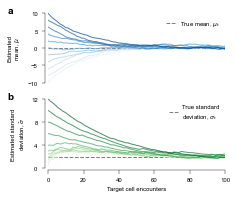

In [13]:
# Fig 1 Code 2/2 plottting

alpha = 10
kappa = 20
m_env = 0
var_env = 4
num_encounter = 100

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sestimated_mean_std.csv.gz' %
                   DATA_FOLDER, compression='gzip')
# Plotting -----------------------------------------------
# fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.85))
# plt.rc('font', size=LABEL_SIZE, family=FAMILY)
# ax1 = fig.add_axes([0.23, 0.57, 0.735, 0.36])
# ax2 = fig.add_axes([0.23, 0.125, 0.735, 0.36])

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.93, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
fig.text(0.03, 0.485, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

# Case 1 different means and same variance ---------------
mu_c = sns.color_palette('Blues', n_colors=num_means)
for j_mu in range(num_means):
    mean = data.loc[(data['alpha'] == alpha) 
                    & (data['Initial mean'] == initial_means[j_mu]) 
                    & (data['Initial std'] == initial_std)]['Mean']
    encouner = range(len(mean))
    ax1.plot(encouner, mean, alpha=0.7, c=mu_c[j_mu])


# Case 2 initial same mu and different var ---------------
std_c = sns.color_palette('Greens', n_colors=num_stds)
for j_std in range(num_stds):
    std = data.loc[(data['alpha'] == alpha) 
                   & (data['Initial mean'] == initial_mean) 
                   & (data['Initial std'] == initial_stds[j_std])]['Std']
    encounter = range(len(std))
    ax2.plot(encounter, std, alpha=0.7, c=std_c[j_std])

plt.savefig('fig2-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

##  Generation of data for evolution of estimated mean, standard deviation and probaility of activation.

In [14]:
# Fig3 global variables
#global variable
num_cell = 500
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# Fig 3 1/2 data for Finite memory of past interactions with
# target cells results in heterogeneous immune cell behaviors.
df = pd.DataFrame({'alpha': [],
                   'kappa': [],
                   'True mean': [],
                   'True std': [],
                   'Cell No': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': [],
                   'Beta': [],
                   'Poa': []
                   })
datatype_dict = {'alpha': int,
                 'kappa': int,
                 'True mean': float,
                 'True std': float,
                 'Cell No': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float,
                 'Beta': float,
                 'Poa': float
                 }
df = df.astype(datatype_dict)

# loop over num_cell
for i_cell in range(num_cell):
    # healthy environment
    mean, std = update(m_env1, math.sqrt(var_env1), alpha,
                       kappa, num1env, m_env1, var_env1)
    # unhealthy environment
    a, b = update(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
    mean += a
    std += b
    # healthy environment
    a, b = update(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
    mean += a
    std += b
    # calculate beta and poa
    beta = [item**2*(alpha-1) for item in std]
    poa = [POA(alpha, kappa, item1, item2, m_env2, var_env2)
           for item1, item2 in zip(mean, beta)]
    # for nstep in range(total_num):
    #	beta[nstep] = std[nstep]**2*(alpha-1)
    #	poa[nstep] = POA(alpha, kappa, mean[nstep], beta[nstep], m_env2, var_env2)
    # data saving ----------------------------------------------------
    df2 = pd.DataFrame({'alpha': [alpha]*total_num,
                        'kappa': [kappa]*total_num,
                        'True mean': [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env,
                        'True std': [math.sqrt(var_env1)]*num1env
                                    + [math.sqrt(var_env2)]*num2env
                                    + [math.sqrt(var_env1)]*num3env,
                        'Cell No': [i_cell]*total_num,
                        'Encounters': np.arange(total_num),
                        'Mean': mean,
                        'Std': std,
                        'Beta': beta,
                        'Poa': poa
                        })
    df = pd.concat([df, df2])
print(df.head())
df.to_csv('MultiEnvs_MultiCells_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('MultiEnvs_MultiCells_mean_std_beta_poa data done')

   alpha  kappa  True mean  True std  Cell No  Encounters      Mean       Std  \
0     10     20        0.0       1.0        0           0  0.000000  1.000000   
1     10     20        0.0       1.0        0           1 -0.020388  0.978037   
2     10     20        0.0       1.0        0           2  0.003138  0.958357   
3     10     20        0.0       1.0        0           3  0.005573  0.932866   
4     10     20        0.0       1.0        0           4  0.027743  0.913948   

       Beta       Poa  
0  9.000000  0.898182  
1  8.609014  0.904638  
2  8.266025  0.906726  
3  7.832150  0.911647  
4  7.517716  0.913579  
MultiEnvs_MultiCells_mean_std_beta_poa data done


# Figure 2. Immune cells adapt to changing environments, mimicking experimentally observed development of hyposensitivity and recovery

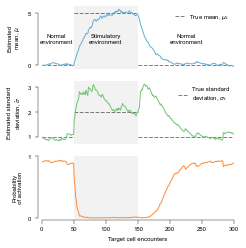

In [14]:
# Fig 2.

alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.26])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.26])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.26])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2, 3])
ax2.set_yticklabels([1, 2, 3])
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey', lw=0)

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

ax2.hlines(y=math.sqrt(var_env1), xmin=0, xmax=num1env,
           label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env2), xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=math.sqrt(var_env1), xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

#ax3.hlines(0.99, 0, num1env, **DASH_STYLE)
#ax3.hlines(0, num1env, num1env+num2env, **DASH_STYLE)
#ax3.hlines(0.99, num1env+num2env,num1env+num2env+num3env, **DASH_STYLE)

ax1.spines['left'].set_bounds(0, 5)
#ax2.set_ylim(0, 3)
ax2.spines['left'].set_bounds(1, 3)
ax3.set_ylim(-0.01, 1)
ax3.spines['left'].set_bounds(0, 1)
#ax3.set_yticks(np.arange(0, 1.1, step=1))

# plot
mu_c = sns.color_palette('Blues', n_colors=1)
std_c = sns.color_palette('Greens', n_colors=1)
poa_c = sns.color_palette('Oranges', n_colors=1)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)
ax1.plot(data.loc[data['Cell No'] == 0]['Mean'], c=mu_c[0])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data.loc[data['Cell No'] == 0]['Std'], c=std_c[0])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data.loc[data['Cell No'] == 0]['Poa'], c=poa_c[0])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')

ax1.text(23, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(100, 2.5, 'Stimulatory\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)
ax1.text(225, 2.5, 'Normal\nenvironment',
         ha='center', va='center', fontsize=LABEL_SIZE)

plt.savefig('fig3-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 3. Finite memory of past interactions with target cells results in heterogeneous immune cell behaviors

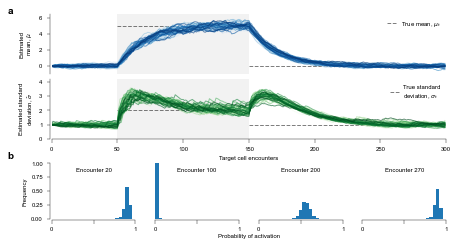

In [6]:
# Fig3

num_cell = 500
num_lines = 50
alpha = 10
kappa = 20
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 100
num3env = 150
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv(
    '%sMultiEnvs_MultiCells_mean_std_beta_poa.csv.gz' % (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(DOUBLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(
    0.05, 0.95, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.05, 0.35, string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')

ax1 = fig.add_axes([0.14, 0.7, 0.8, 0.25])
ax2 = fig.add_axes([0.14, 0.43, 0.8, 0.25])
ax3 = fig.add_axes([0.14, 0.1, 0.17, 0.23])
ax4 = fig.add_axes([0.35, 0.1, 0.17, 0.23])
ax5 = fig.add_axes([0.56, 0.1, 0.17, 0.23])
ax6 = fig.add_axes([0.77, 0.1, 0.17, 0.23])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.005))
ax1.spines['bottom'].set_position(('axes', -0.005))
ax2.spines['left'].set_position(('axes', -0.005))
ax2.spines['bottom'].set_position(('axes', -0.005))
ax1.set_ylim(-1, 6.5)
ax2.set_ylim(0, 4.2)
ax1.set_xlim(0, 300)
ax2.set_xlim(0, 300)
ax1.set_xticks([])

ax1.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax2.axvspan(50, 150, alpha=0.1, color='grey', lw=0)
ax1.hlines(0, xmin=-10, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(5, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(0, xmin=num1env+num2env, xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=1, xmin=-10, xmax=num1env, label=TRUE_STD_LABEL, **DASH_STYLE)
ax2.hlines(y=2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=1, xmin=num1env+num2env, xmax=num1env +
           num2env+num3env, **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False, handlelength=1.5)
ax2.legend(loc='upper right', frameon=False, handlelength=1.5)

mu_c = sns.color_palette('Blues', n_colors=num_lines)
std_c = sns.color_palette('Greens', n_colors=num_lines)
for i_cell in range(num_lines):
    ax1.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Mean'], alpha=0.6, c=mu_c[i_cell])
ax1.set_ylabel(ESTD_MEAN_LABEL)

for i_cell in range(num_lines):
    ax2.plot(np.arange(total_num),
             data.loc[data['Cell No'] == i_cell]['Std'], alpha=0.6, c=std_c[i_cell])
ax2.set_ylabel(ESTD_STD_LABEL)

ax2.set_xlabel(ENCOUNTER_LABEL)

#ax3.set_ylabel('Probability of activation (%)')
ax3.set_xticks(np.arange(0, 1.01, step=0.5))
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax5.set_xticks(np.arange(0, 1.01, step=0.5))
ax6.set_xticks(np.arange(0, 1.01, step=0.5))
ax3.set_xticklabels(['0', '', '1'])
ax4.set_xticklabels(['0', '', '1'])
ax5.set_xticklabels(['0', '', '1'])
ax6.set_xticklabels(['0', '', '1'])
ax3.set_ylim([0, 1])
ax4.set_ylim([0, 1])
ax5.set_ylim([0, 1])
ax6.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
ax5.set_xlim([0, 1])
ax6.set_xlim([0, 1])
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.spines['left'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))
ax5.spines['bottom'].set_position(('axes', -0.02))
ax6.spines['bottom'].set_position(('axes', -0.02))

ax3.set_ylabel('Frequency')
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])

binstep = 0.04
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

xbins = []
for ibin in range(int(1.0/binstep)):
    xbins.append(binstep*ibin)

# -----------------------------

step_vals = [20, 100, 200, 270]
axes = [ax3, ax4, ax5, ax6]

for nstep, ax in zip(step_vals, axes):
    pointpoas = data.loc[data['Encounters'] == nstep]['Poa']
    statist = np.histogram(pointpoas, bins)[0]/num_cell
    ax.bar(xbins, height=statist, width=binstep, align='edge')
    ax.text(0.5, 0.85, 'Encounter %d' %
            nstep, ha='center', fontsize=LABEL_SIZE, color='k')

# ----------------------
fig.text(0.54, 0.02, POA_LABEL, ha='center')
plt.savefig('fig3-adaptation-dynamic-population.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 4. Steady state distribution of immune cell adaptation and responsiveness due to finite memory

## Part 1. Solve the Fokker Planck Equation (See FKE.py which generates 'Fokker_planck_solution.csv.gz')

## Part 2. Calculate the probability of activation

In [38]:
# Fig 4 variables
u2 = 2  # data mean
sigma2 = 1  # data std
theta = 0.01
alpha = 10
kappa = 20
c1 = (alpha-1)/(alpha-0.5)
# constant in betanew = c1*beta + c2*(x-mu)**2
c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)

# Fig 4 2/3 Steady state distribution of immune cell adaptation and responsiveness due to finite memory.
# part 2 For each set of (\mu,\beta) calculate the probability of activation.
alpha = 10
kappa = 20

# antigen N(4.5,1)
mean_antigen = 4.5  # this value is where POA of the center
var_antigen = 1

# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

m = [0]*(NX*NY)
beta = [0]*(NX*NY)
poa = [0]*(NX*NY)
for i in range(NX):
    for j in range(NY):
        m[i*NY+j] = xmin+i*dx
        beta[i*NY+j] = ymin+j*dy
        poa[i*NY+j] = POA(alpha, kappa, m[i*NY+j],
                          beta[i*NY+j], mean_antigen, var_antigen)
df = pd.DataFrame()
df['alpha'] = [alpha]*(NX*NY)
df['kappa'] = [kappa]*(NX*NY)
df['Antigen mean'] = [mean_antigen]*(NX*NY)
df['Antigen var'] = [var_antigen]*(NX*NY)
df['M'] = m
df['Beta'] = beta
df['Poa'] = poa
df.to_csv('poa_matrix.csv.gz', index=None, header=True, compression='gzip')
print('Fig 4 poa matrix done')

Fig 4 poa matrix done


## Part 3. Plotting

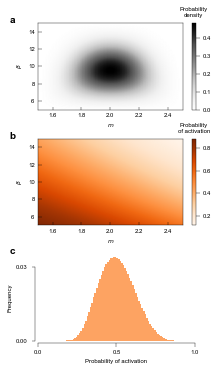

In [15]:
# Fig 4 3/3
# grid
NX = 101
NY = 1001
xmax = 2.5
xmin = 1.5
ymax = 15
ymin = 5
dx = (xmax-xmin)/(NX-1)
dy = (ymax-ymin)/(NY-1)

# load data
dataw = pd.read_csv('%sFokker_planck_solution.csv.gz' %
                    (DATA_FOLDER), compression='gzip')
col = dataw.columns[-1]
w = dataw[col]
w = np.array(w).reshape((NX, NY))
data = pd.read_csv('%spoa_matrix.csv.gz' % (DATA_FOLDER), compression='gzip')
poa = np.array(data['Poa']).reshape((NX, NY))

# plotting ---------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
h = 0.24
s = 0.08
ax1 = fig.add_axes([0.15, 0.95 - h, 0.75, h])
ax2 = fig.add_axes([0.15, 0.95 - 2*h - s, 0.75, h])
ax3 = fig.add_axes([0.15, 0.95 - 3*h - 2*s, 0.65, h])
fig.text(
    0.03, 0.95, string.ascii_uppercase[0].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - (h+s), string.ascii_uppercase[1].lower(), size=SUBLABEL_SIZE, weight='bold')
fig.text(
    0.03, 0.95 - 2*(h+s), string.ascii_uppercase[2].lower(), size=SUBLABEL_SIZE, weight='bold')
ax1.tick_params(direction='in')
ax2.tick_params(direction='in')
#ax3.tick_params(direction='in')

ax1.set_xlabel(r'$m$')
ax1.set_ylabel(r'$\beta$')
ax2.set_xlabel(r'$m$')
ax2.set_ylabel(r'$\beta$')

ax3.set_xlabel(POA_LABEL)
ax3.set_ylabel('Frequency')
ax3.set_xlim([0, 1])
ax3.set_ylim([-0.0002, 0.035])
ax3.set_yticks([0, 0.03])
ax3.spines['left'].set_bounds(0, 0.03)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
X = xmin+dx*np.arange(NX)
Y = ymin+dy*np.arange(NY)

colorinterpolation = 50  # Set colour interpolation and colour map
# .T means transpose because contourf treat T[i,j] as X[j] Y[i]
#pos1  = ax1.contourf(X, Y, w.T, colorinterpolation, cmap=plt.cm.get_cmap('Greys'))
pos1 = ax1.pcolormesh(X, Y, w.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Greys'))
cbar1 = fig.colorbar(pos1, ax=ax1)
cbar1.ax.set_title('Probability\ndensity', fontsize=LABEL_SIZE)
cbar1.set_ticks(np.arange(0, 0.9, step=0.1))

#pos2  = ax2.contourf(X, Y, poa.T, colorinterpolation, cmap=plt.cm.get_cmap('Blues'))
pos2 = ax2.pcolormesh(X, Y, poa.T, shading='gouraud',
                      cmap=plt.cm.get_cmap('Oranges'))
cbar2 = fig.colorbar(pos2, ax=ax2)
cbar2.ax.set_title('Probability\nof activation', fontsize=LABEL_SIZE)
cbar2.set_ticks(np.arange(0, 1, step=0.2))

# bins for poa histgram
poa_c = sns.color_palette('Oranges', n_colors=1)
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)
xbin = []
y3 = []
for ibin in range(int(1.0/binstep)):
    xbin.append((ibin+0.5)*binstep)
    y3.append(0)
for ix in range(NX):
    for iy in range(NY):
        ibin = 0
        while ibin*binstep < poa[ix, iy]:
            ibin += 1
        y3[ibin] += w[ix, iy]
y3plot = [float(i)/sum(y3) for i in y3]
#ax3.plot(xbin, y3plot, color='black', linestyle='dashed')
ax3.bar(xbin, height=y3plot, width=binstep, align='center', alpha=0.8, facecolor=poa_c[0])
ax3.set_xticks([0, 0.5, 1])

plt.savefig('fig4-heterogeneity.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# Figure 5. Immune cells responses are diverse, but follow predictable trends de- pending on the level of stimulation received from target cells. 

## Part 1. Evolution of (mu, beta) in different memory and calculate the corresponding POA

In [71]:
def update_mubeta(initial_mean, initial_beta, alpha, kappa, num_encounter, m_env, var_env):
    c1 = (alpha-1)/(alpha-0.5)
    # constant in betanew = c1*beta + c2*(x-mu)**2
    c2 = 0.5*(alpha-1)/(alpha-0.5)*kappa/(kappa+1)
    mean_old = initial_mean
    beta_old = initial_beta
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        mean_new = (kappa*mean_old+x)/(kappa+1)
        beta_new = c1*beta_old+c2*(x-mean_old)**2
        mean_old, beta_old = mean_new, beta_new
    return(mean_new, beta_new)


# Fig 5 global variables
num_cells = 100000  # 100000
num_encounter = 1000
m_env = 2
var_env = 1
u2s = [6, 5, 4, 3]
alpha_vals = [5, 10, 20, 50]
var2 = 1
num_u2s = len(u2s)

df = pd.DataFrame({'alpha': [],
                   'Cell No': [],
                   'Antigen mean': [],
                   'Antigen std': [],
                   'M': [],
                   'Beta': [],
                   'Poa': []
                   })
datatype_dict = {'alpha': int,
                 'Cell No': int,
                 'Antigen mean': float,
                 'Antigen std': float,
                 'M': float,
                 'Beta': float,
                 'Poa': float
                 }
df = df.astype(datatype_dict)

# initial distribution form and number of NK cells
init_m = [0]*num_cells
init_beta = [0]*num_cells
for i in range(num_cells):
    init_m[i] = random.random()*5  # [0,5)
    init_beta[i] = random.random()*40  # [0,40)

# loop to get mu beta distribution after num_encounter steps
for u2 in u2s:
    print('target mean', u2)
    for alpha in alpha_vals:
        print('alpha', alpha)
        print(timer())
        kappa = 2*alpha
        m = np.zeros(num_cells)
        beta = np.zeros(num_cells)
        poa = np.zeros(num_cells)
        for i_cell in range(num_cells):
            if i_cell % 10000 == 0:
                print(i_cell, timer())
            m[i_cell], beta[i_cell] = update_mubeta(init_m[i_cell], init_beta[i_cell],
                                                    alpha, kappa, num_encounter, m_env, var_env)
            poa[i_cell] = POA(alpha, kappa, m[i_cell], beta[i_cell], u2, var2)
        df2 = pd.DataFrame({'alpha': [alpha]*num_cells,
                            'Cell No': np.arange(num_cells),
                            'Antigen mean': [u2]*num_cells,
                            'Antigen std': [var2]*num_cells,
                            'M': m,
                            'Beta': beta,
                            'Poa': poa
                            })
        df = pd.concat([df, df2])
df.to_csv('diff_memory_population.csv.gz',
          index=None, header=True, compression='gzip')
print('update mu beta done')

target mean 6
alpha 5
22363.069209552
0 22363.069572142
10000 22374.172634891
20000 22385.141674321
30000 22396.176357874
40000 22407.126599577
50000 22418.166396487
60000 22429.04159289
70000 22439.928496489
80000 22450.894949832
90000 22461.805445731
alpha 10
22472.725368268
0 22472.725836343
10000 22483.61515215
20000 22494.523474735
30000 22505.61715896
40000 22516.455070558
50000 22530.006898298
60000 22541.220348301
70000 22552.736579878
80000 22563.846468046
90000 22575.632115753
alpha 20
22586.691595028
0 22586.69202375
10000 22597.67059859
20000 22608.676242667
30000 22619.693298625
40000 22630.733390105
50000 22641.686559119
60000 22653.608384139
70000 22664.777650205
80000 22675.751544075
90000 22686.734981571
alpha 50
22697.766673765
0 22697.767076144
10000 22708.747585592
20000 22719.73956204
30000 22730.720909513
40000 22741.732557938
50000 22752.837207813
60000 22763.830387378
70000 22774.93591103
80000 22785.969668558
90000 22797.259691511
target mean 5
alpha 5
22808.20

## Part 2. Plotting

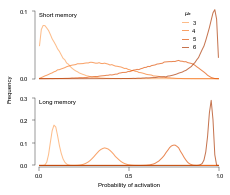

In [5]:
# Fig 5 1/2 different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('%sdiff_memory_population.csv.gz' %
                   DATA_FOLDER, compression='gzip')

alpha_vals = [5, 10, 20, 50]
num_cells = 100000

# grid
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

# grid
x = []
binstep = 0.01
for ibin in range(int(1.0/binstep)):
    x.append((ibin+0.5)*binstep)

# figure
w = 0.75
h = 0.35

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(0.03, 0.55, 'Frequency', rotation='vertical',
         ha='center', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.93, 'Short memory',
         ha='left', va='center', fontsize=LABEL_SIZE)
fig.text(0.15, 0.83-h, 'Long memory',
         ha='left', va='center', fontsize=LABEL_SIZE)

ax1 = fig.add_axes([0.15, 0.95-1*h, w, h])
ax2 = fig.add_axes([0.15, 0.85-2*h, w, h])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax1.set_ylim([0, 0.10])
ax2.set_ylim([0, 0.30])
ax1.set_yticks([0, 0.1])
ax2.set_yticks([0, 0.1, 0.2, 0.3])

ax1.set_xticks([])
ax2.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False, labelbottom=False)
ax2.set_xlabel(POA_LABEL)

poa_c = sns.color_palette('Oranges', n_colors=6)

u_vals = [3, 4, 5, 6]

for i in range(len(u_vals)):
    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 5)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax1.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2], label=u_vals[i])

    poas = data.loc[(data['Antigen mean'] == u_vals[i]) &
                    (data['alpha'] == 50)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax2.plot(x, y, alpha=0.7, clip_on=False, c=poa_c[i+2])

    # ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax1.legend(title=r'$\mu_a$', loc='center', bbox_to_anchor=(
    0.83, 0.73), borderaxespad=0, ncol=1, handlelength=1, frameon=False)


plt.savefig('fig5-heterogeneity-response.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

step1
step2
step3
step4


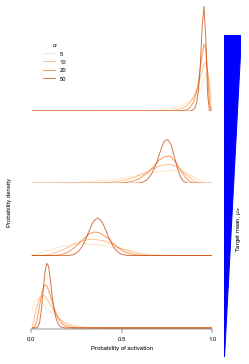

In [20]:
# Fig 5 1/2 different memory length, NK cell response are heterogeneous
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
data = pd.read_csv('%sdiff_memory_population.csv.gz' %
                   DATA_FOLDER, compression='gzip')

alpha_vals = [5, 10, 20, 50]
num_cells = 100000

# grid
binstep = 0.01
bins = []
for ibin in range(1+int(1.0/binstep)):
    bins.append(binstep*ibin)

# grid
x = []
binstep = 0.01
for ibin in range(int(1.0/binstep)):
    x.append((ibin+0.5)*binstep)

# figure
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
fig.text(0.01, 0.5, 'Probability density', rotation='vertical',
         ha='center', va='center', fontsize=LABEL_SIZE)

w = 0.75
h = 0.20
ax0 = fig.add_axes([0.90, 0.07, 0.07, 0.89])
ax1 = fig.add_axes([0.10, 0.95-1*h, w, h])
ax2 = fig.add_axes([0.10, 0.95-2*h, w, h])
ax3 = fig.add_axes([0.10, 0.95-3*h, w, h])
ax4 = fig.add_axes([0.10, 0.95-4*h, w, h])
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
#ax1.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
#ax2.spines['left'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
#ax3.spines['left'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
#ax4.spines['left'].set_position(('axes', -0.02))
ax4.spines['bottom'].set_position(('axes', -0.02))

ax1.set_xlim([0, 1])
ax2.set_xlim([0, 1])
ax3.set_xlim([0, 1])
ax4.set_xlim([0, 1])
# ax1.set_ylim([0, 0.3])
# ax2.set_ylim([0, 0.3])
# ax3.set_ylim([0, 0.3])
# ax4.set_ylim([0, 0.3])
ax1.set_ylim([0, 0.20])
ax2.set_ylim([0, 0.15])
ax3.set_ylim([0, 0.15])
ax4.set_ylim([0, 0.20])
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])
ax4.set_xticks(np.arange(0, 1.01, step=0.5))
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax3.tick_params(top=False, labelbottom=False)

ax4.set_xlabel(POA_LABEL)

ax0.text(0.8, 0.4, r'Target mean, $\mu_{a}$', ha='center', va='center', rotation='vertical',
         transform=ax0.transAxes, fontsize=LABEL_SIZE)
triangle = ([(0, 0), (0, 1), (1, 1)])
trip = mpl.patches.Polygon(triangle, closed=True, color='blue')
ax0.add_patch(trip)
ax0.axis('off')

poa_c = sns.color_palette('Oranges', n_colors=len(alpha_vals))

print('step1')
u2 = 6
cmap = plt.get_cmap('seismic')
dicmap = {5: 0.1, 10: 0.3, 20: 0.65, 50: 0.95}
for mem_alpha in alpha_vals:
    #y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    poas = data.loc[(data['Antigen mean'] == u2) &
                    (data['alpha'] == mem_alpha)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax1.plot(x, y, label='%d' % mem_alpha, alpha=0.7, clip_on=False,
             c=poa_c[alpha_vals.index(mem_alpha)])
             #c=cmap(dicmap[mem_alpha]))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.legend(title=r'$\alpha$', bbox_to_anchor=(
    0.05, 1), loc=2, borderaxespad=0, frameon=False, handlelength=1)

print('step2')
u2 = 5
for mem_alpha in alpha_vals:
    #y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    poas = data.loc[(data['Antigen mean'] == u2) &
                    (data['alpha'] == mem_alpha)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax2.plot(x, y, alpha=0.7, clip_on=False,
             c=poa_c[alpha_vals.index(mem_alpha)])
             #c=cmap(dicmap[mem_alpha]))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

print('step3')
u2 = 4
for mem_alpha in alpha_vals:
    #y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    poas = data.loc[(data['Antigen mean'] == u2) &
                    (data['alpha'] == mem_alpha)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax3.plot(x, y, alpha=0.7, clip_on=False,
             c=poa_c[alpha_vals.index(mem_alpha)])
             #c=cmap(dicmap[mem_alpha]))

print('step4')
u2 = 3
for mem_alpha in alpha_vals:
    #y = data['target_mean_%d_alpha_%d' % (u2, mem_alpha)]/num_cells
    poas = data.loc[(data['Antigen mean'] == u2) &
                    (data['alpha'] == mem_alpha)]['Poa']
    y = np.histogram(poas, bins)[0]/num_cells
    ax4.plot(x, y, alpha=0.7, clip_on=False,
             c=poa_c[alpha_vals.index(mem_alpha)])
             #c=cmap(dicmap[mem_alpha]))
    ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig('fig5-heterogeneity-response.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figures

# SI Figure 1. Immune cells adapt to a static environment under different memory

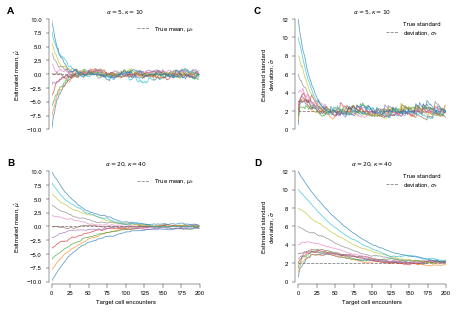

In [31]:
# SI Fig 1  different memory
# Compare alpha = 5 vs 20

alphas = [5, 20]
kappas = [10, 40]
alpha_shortmem = 5
kappa_shortmem = 10
alpha_longmem = 20
kappa_longmem = 40
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

if __name__ == '__main__':
    fig = plt.figure(figsize=(DOUBLE_COLUMN, 4.5))
    plt.rc('font', size=LABEL_SIZE, family=FAMILY)
    ax1 = fig.add_axes([0.15, 0.59, 0.3, 0.34])
    ax2 = fig.add_axes([0.15, 0.12, 0.3, 0.34])
    ax3 = fig.add_axes([0.65, 0.59, 0.3, 0.34])
    ax4 = fig.add_axes([0.65, 0.12, 0.3, 0.34])
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax1.spines['left'].set_position(('axes', -0.02))
    ax3.spines['left'].set_position(('axes', -0.02))
    ax2.spines['bottom'].set_position(('axes', -0.02))
    ax2.spines['left'].set_position(('axes', -0.02))
    ax4.spines['bottom'].set_position(('axes', -0.02))
    ax4.spines['left'].set_position(('axes', -0.02))
    ax1.set_xlim([0, num_encounter])
    ax1.set_ylim([-10, 10])
    ax2.set_xlim([0, num_encounter])
    ax2.set_ylim([-10, 10])
    ax3.set_xlim([0, num_encounter])
    ax3.set_ylim([0, 12])
    ax4.set_xlim([0, num_encounter])
    ax4.set_ylim([0, 12])

    ax1.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax1.legend(loc='upper right', frameon=False)
    ax1.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax1.text(-0.3, 1.05, string.ascii_uppercase[0].lower(),
             transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax1.set_title(r'$\alpha=5, \kappa=10$', fontsize=LABEL_SIZE)

    ax2.axhline(m_env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
    ax2.legend(loc='upper right', frameon=False)
    ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax2.set_ylabel('Estimated mean, $\hat{\mu}$', fontsize=LABEL_SIZE)
    ax2.text(-0.3, 1.05, string.ascii_uppercase[1].lower(),
             transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax2.set_title(r'$\alpha=20, \kappa=40$', fontsize=LABEL_SIZE)

    ax3.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax3.legend(loc='upper right', frameon=False)
    ax3.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax3.text(-0.3, 1.05, string.ascii_uppercase[2].lower(),
             transform=ax3.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax3.set_title(r'$\alpha=5, \kappa=10$', fontsize=LABEL_SIZE)

    ax4.axhline(math.sqrt(var_env), label=TRUE_STD_LABEL, **DASH_STYLE)
    ax4.legend(loc='upper right', frameon=False)
    ax4.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
    ax4.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
    ax4.text(-0.3, 1.05, string.ascii_uppercase[3].lower(),
             transform=ax4.transAxes, size=SUBLABEL_SIZE, weight='bold')
    ax4.set_title(r'$\alpha=20, \kappa=40$', fontsize=LABEL_SIZE)

    # different initial mu and same var ------------------------------------
    data = pd.read_csv('%sestimated_mean_std.csv.gz' %
                       DATA_FOLDER, compression='gzip')
    for j_mu in range(num_means):
        mean_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                 (data['kappa'] == kappa_shortmem) &
                                 (data['Initial mean'] == initial_means[j_mu]) &
                                 (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_shortmem))
        ax1.plot(encouner, mean_shortmem, alpha=0.7)
        mean_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                                (data['kappa'] == kappa_longmem) &
                                (data['Initial mean'] == initial_means[j_mu]) &
                                (data['Initial std'] == initial_std)]['Mean']
        encouner = range(len(mean_longmem))
        ax2.plot(encouner, mean_longmem, alpha=0.7)

    for j_std in range(num_stds):
        std_shortmem = data.loc[(data['alpha'] == alpha_shortmem) &
                                (data['kappa'] == kappa_shortmem) &
                                (data['Initial mean'] == initial_mean) &
                                (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_shortmem))
        ax3.plot(encounter, std_shortmem, alpha=0.7)
        std_longmem = data.loc[(data['alpha'] == alpha_longmem) &
                               (data['kappa'] == kappa_longmem) &
                               (data['Initial mean'] == initial_mean) &
                               (data['Initial std'] == initial_stds[j_std])]['Std']
        encounter = range(len(std_longmem))
        ax4.plot(encounter, std_longmem, alpha=0.7)
    plt.savefig('figSI1-adaptation-memory.pdf', format='pdf', dpi=300)
    plt.show()
    plt.close()

# Signal modified by Sigmoid function

In [7]:
# use modified signal to update the mean and variance
def update2(initial_mean, initial_std, alpha, kappa, num_encounter, m_env, var_env):
    # constants in equtions for variance updating
    varc1 = (alpha-1)/(alpha-0.5)
    varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
    mean = [0]*num_encounter
    std = [0]*num_encounter
    mean[0] = initial_mean
    std[0] = initial_std
    for nstep in range(1, num_encounter):
        x = random.gauss(m_env, math.sqrt(var_env))  # gauss(mean,std)
        x = mean[nstep-1]+(2/(1 + math.exp(-(x - mean[nstep-1]))) - 1)*2
        mean[nstep] = (kappa*mean[nstep-1]+x)/(kappa+1)
        std[nstep] = math.sqrt(varc1*std[nstep-1]**2 +
                               varc2*(x-mean[nstep-1])**2)
    return(mean, std)

# Si Figure 3

In [8]:
alpha = 10
kappa = 20
m_env = 0
var_env = 4
num_encounter = 200

# Fig 1 Code 1/2
df = pd.DataFrame({'Initial mean': [],
                   'Initial std': [],
                   'True mean': [],
                   'True std': [],
                   'alpha': [],
                   'kappa': [],
                   'Encounters': [],
                   'Mean': [],
                   'Std': []
                   })
datatype_dict = {'Initial mean': float,
                 'Initial std': float,
                 'True mean': float,
                 'True std': float,
                 'alpha': int,
                 'kappa': int,
                 'Encounters': int,
                 'Mean': float,
                 'Std': float
                 }
df = df.astype(datatype_dict)

# part 1. initial different mean and same var ------------------------------------
initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)
for i_case in range(num_means):
    initial_mean = initial_means[i_case]
    mean, std = update2(initial_mean, initial_std, alpha,
                        kappa, num_encounter, m_env, var_env)
    num_rows = len(mean)
    df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                        'Initial std': [initial_std]*num_rows,
                        'True mean': [m_env]*num_rows,
                        'True std': [math.sqrt(var_env)]*num_rows,
                        'alpha': [alpha]*num_rows,
                        'kappa': [kappa]*num_rows,
                        'Encounters': np.arange(num_rows),
                        'Mean': mean,
                        'Std': std
                        })
    df = pd.concat([df, df2])

# part 2. initial same mean and different var ------------------------------------
initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)
for i_case in range(num_means, num_means+num_stds):
    initial_std = initial_stds[i_case-num_means]
    mean, std = update2(initial_mean, initial_std, alpha,
                        kappa, num_encounter, m_env, var_env)
    num_rows = len(mean)
    df2 = pd.DataFrame({'Initial mean': [initial_mean]*num_rows,
                        'Initial std': [initial_std]*num_rows,
                        'True mean': [m_env]*num_rows,
                        'True std': [math.sqrt(var_env)]*num_rows,
                        'alpha': [alpha]*num_rows,
                        'kappa': [kappa]*num_rows,
                        'Encounters': np.arange(num_rows),
                        'Mean': mean,
                        'Std': std
                        })
    df = pd.concat([df, df2])

df.to_csv('SI3_estimated_mean_std_alpha%d.csv.gz' %
          alpha, index=None, header=True, compression='gzip')
print('Fig SI 3 data done')

Fig SI 3 data done


# The shift in standard deviation 

In [3]:
#Transformed signal variance calculation\n",
#sigmoid function t = m+L*(2/(1+e^{-x})-1) , where x~N(mu, sigma^2), L=2, t~[m-L,m+L], y=t-m\n",
# Thus y probability distribution P(y) = 1/(sqrt(2*pi)*sigma) * 4/(4-(y-m)^2) * e^(-0.5*(m-mu-ln(4/(2+(y-m))-1))^2/sigma^2),\n",
# where y~[m-2,m+2], cause m is unknow and eventually converges to mu, here set m=mu\n",
# expected value of y E(y) = NIntegrate(yP(y),{y,-2,2})\n",# Transformed signal variance calculation
# variance var(y) = NIntegrate(y^2P(y)-E(y)^2, {y,-2,2})\n",
def transformed_std(m,sigma):
	firstmom = quad(lambda t: t*4/(math.sqrt(2*math.pi)*sigma*(4-(t-m)**2))*math.exp(-
					(math.log(4/(2+(t-m))-1))**2/(2*sigma**2)),-2,2)[0]
	secondmom = quad(lambda t: t**2*4/(math.sqrt(2*math.pi)*sigma*(4-(t-m)**2))*math.exp(-
						(math.log(4/(2+(t-m))-1))**2/(2*sigma**2)),-2,2)[0]
	return(math.sqrt(secondmom-firstmom**2))
# calculate (mu,sigma)=(0,1) and (0,2) which are used in following Figure s3, s4 \n",
std_2_tf = transformed_std(0,2) 
std_1_tf = transformed_std(0,1) 
print(std_1_tf,std_2_tf)

0.8331053797184165 1.2558574607014708


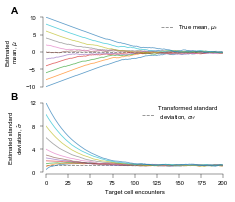

In [8]:
# Fig 1 Code 2/2 plottting

alpha = 10  # 5
kappa = 20  # 10
m_env = 0
var_env = 4
num_encounter = 200

initial_means = np.arange(-10, 11, 2)
initial_std = 1
num_means = len(initial_means)

initial_mean = 5
initial_stds = [0.5, 1, 1.5, 2, 2.5, 3, 4, 6, 8, 10, 12]
num_stds = len(initial_stds)

# read data
data = pd.read_csv('%sSI3_estimated_mean_std_alpha%d.csv.gz' %
                   (DATA_FOLDER, 10), compression='gzip')

# Plotting -----------------------------------------------
# fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.85))
# plt.rc('font', size=LABEL_SIZE, family=FAMILY)
# ax1 = fig.add_axes([0.23, 0.57, 0.735, 0.36])
# ax2 = fig.add_axes([0.23, 0.125, 0.735, 0.36])

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))

ax1 = fig.add_axes([0.20, 0.57, 0.735, 0.36])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax1.set_xlim([0, num_encounter])
ax1.set_ylim([-10, 10])
ax1.set_yticks([-10, -5, 0, 5, 10])
ax1.set_ylabel(ESTD_MEAN_LABEL, fontsize=LABEL_SIZE)
ax1.text(-0.2, 1.05, string.ascii_uppercase[0].lower(),
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax1.axhline(0.0, label=TRUE_MEAN_LABEL, **DASH_STYLE)

ax2 = fig.add_axes([0.20, 0.125, 0.735, 0.36])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax2.set_xlim([0, num_encounter])
ax2.set_ylim([0, 12])
ax2.set_yticks([0, 4, 8, 12])
ax2.set_xlabel(ENCOUNTER_LABEL, fontsize=LABEL_SIZE)
ax2.set_ylabel(ESTD_STD_LABEL, fontsize=LABEL_SIZE)
ax2.text(-0.2, 1.05, string.ascii_uppercase[1].lower(),
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.axhline(
    std_2_tf, label='Transformed standard\n deviation, $\sigma_{tf}$', **DASH_STYLE)
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)

# Case 1 different means and same variance ---------------
for j_mu in range(num_means):
    mean = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] ==
                                                initial_means[j_mu]) & (data['Initial std'] == initial_std)]['Mean']
    encouner = range(len(mean))
    ax1.plot(encouner, mean, alpha=0.7)

# Case 2 initial same mu and different var ---------------
for j_std in range(num_stds):
    std = data.loc[(data['alpha'] == alpha) & (data['Initial mean'] == initial_mean) & (
        data['Initial std'] == initial_stds[j_std])]['Std']
    encounter = range(len(std))
    ax2.plot(encounter, std, alpha=0.7)

plt.savefig('figSI3-adaptation-static.pdf', format='pdf', dpi=300)
plt.show()
plt.close()

# SI Figure 4

In [25]:
# Fig 2 variables
alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# Fig 2 code 1/2 data for 'Single NK cell adapt to new environment'
# mean std and probability of activation evolution
mean = [0]*total_num
std = [0]*total_num
poa = [0]*total_num
beta = [0]*total_num
mean[0] = m_env1
std[0] = math.sqrt(var_env1)
beta[0] = std[0]**2*(alpha-1)
poa[0] = (POA(alpha, kappa, mean[0], beta[0], m_env2, var_env2))

# healthy environment
mean, std = update2(m_env1, math.sqrt(var_env1), alpha,
                    kappa, num1env, m_env1, var_env1)

# unhealthy environment
a, b = update2(mean[-1], std[-1], alpha, kappa, num2env, m_env2, var_env2)
mean += a
std += b

# healthy environment
a, b = update2(mean[-1], std[-1], alpha, kappa, num3env, m_env1, var_env1)
mean += a
std += b

# calculate the poa
for nstep in range(total_num):
    beta[nstep] = std[nstep]**2*(alpha-1)
    poa[nstep] = POA(alpha, kappa, mean[nstep],
                     beta[nstep], m_env2, var_env2)

# data saving ----------------------------------------------------
df = pd.DataFrame()
df['alpha'] = [alpha]*total_num
df['kappa'] = [kappa]*total_num
df['True mean'] = [m_env1]*num1env+[m_env2]*num2env+[m_env1]*num3env
df['True std'] = [math.sqrt(var_env1)]*num1env + \
    [math.sqrt(var_env2)]*num2env+[math.sqrt(var_env1)]*num3env
df['Mean'] = mean
df['Std'] = std
df['Beta'] = beta
df['Poa'] = poa
df.to_csv('SI4_MultiEnvs_mean_std_beta_poa.csv.gz',
          index=None, header=True, compression='gzip')
print('Fig SI 4 data done')

Fig SI 4 data done


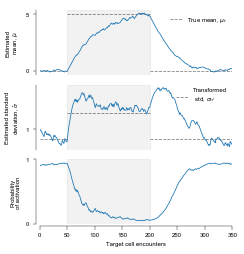

In [9]:
# Fig 2. 2/2

alpha = 10
kappa = 20
# constants in equtions for variance updating
varc1 = (alpha-1)/(alpha-0.5)
varc2 = 0.5*kappa/(kappa+1)/(alpha-0.5)
m_env1 = 0
var_env1 = 1
m_env2 = 5  # mean of second environmental signal and target
var_env2 = 4
num1env = 50
num2env = 150
num3env = 150
total_num = num1env+num2env+num3env

# load data
data = pd.read_csv('%sSI4_MultiEnvs_mean_std_beta_poa.csv.gz' %
                   (DATA_FOLDER), compression='gzip')

# plotting ------------------------------------------------------
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*1.0))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.165, 0.73, 0.8, 0.27])
ax2 = fig.add_axes([0.165, 0.42, 0.8, 0.27])
ax3 = fig.add_axes([0.165, 0.11, 0.8, 0.27])
ax1.tick_params(top=False, labelbottom=False)
ax2.tick_params(top=False, labelbottom=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax1.spines['bottom'].set_visible(False)
ax1.axes.get_xaxis().set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))
ax3.spines['left'].set_position(('axes', -0.02))
ax1.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['bottom'].set_position(('axes', -0.02))
ax3.spines['bottom'].set_position(('axes', -0.02))
ax1.set_xlim(0, total_num)
ax2.set_xlim(0, total_num)
ax3.set_xlim(0, total_num)
ax1.set_yticks([0, 5])
ax1.set_yticklabels([0, 5])
ax2.set_yticks([1, 2])
ax2.set_yticklabels([1, 2])
ax3.set_yticks([0, 1])
ax1.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax2.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')
ax3.axvspan(num1env, num1env+num2env, alpha=0.1, color='grey')

ax1.hlines(y=m_env1, xmin=0, xmax=num1env, label=TRUE_MEAN_LABEL, **DASH_STYLE)
ax1.hlines(y=m_env2, xmin=num1env, xmax=num1env+num2env, **DASH_STYLE)
ax1.hlines(y=m_env1, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)
ax2.hlines(y=std_1_tf, xmin=0, xmax=num1env,
           label='Transformed\n std, $\sigma_{tf}$', **DASH_STYLE)
ax2.hlines(y=std_2_tf, xmin=num1env,
           xmax=num1env+num2env, **DASH_STYLE)
ax2.hlines(y=std_1_tf, xmin=num1env+num2env,
           xmax=num1env+num2env+num3env, **DASH_STYLE)

#ax3.hlines(0.99, 0, num1env, **DASH_STYLE)
#ax3.hlines(0, num1env, num1env+num2env, **DASH_STYLE)
#ax3.hlines(0.99, num1env+num2env,num1env+num2env+num3env, **DASH_STYLE)

ax3.set_ylim(-0.01, 1)
#ax3.set_yticks(np.arange(0, 1.1, step=1))

# plot
ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='upper right', frameon=False)
ax1.plot(data['Mean'])
ax1.set_ylabel(ESTD_MEAN_LABEL)
ax2.plot(data['Std'])
ax2.set_ylabel(ESTD_STD_LABEL)
ax3.plot(data['Poa'])
ax3.set_xlabel(ENCOUNTER_LABEL)
ax3.set_ylabel('Probability\nof activation')
plt.savefig('figSI4-adaptation-dynamic.pdf', format='pdf', dpi=300)
plt.show()
plt.close()